# Fruit Image Classifier Project Report

## **Develop by :** Kevin Marakana 


## 1. Project Title
**Fruit Image Classification using Convolutional Neural Networks (CNN)**


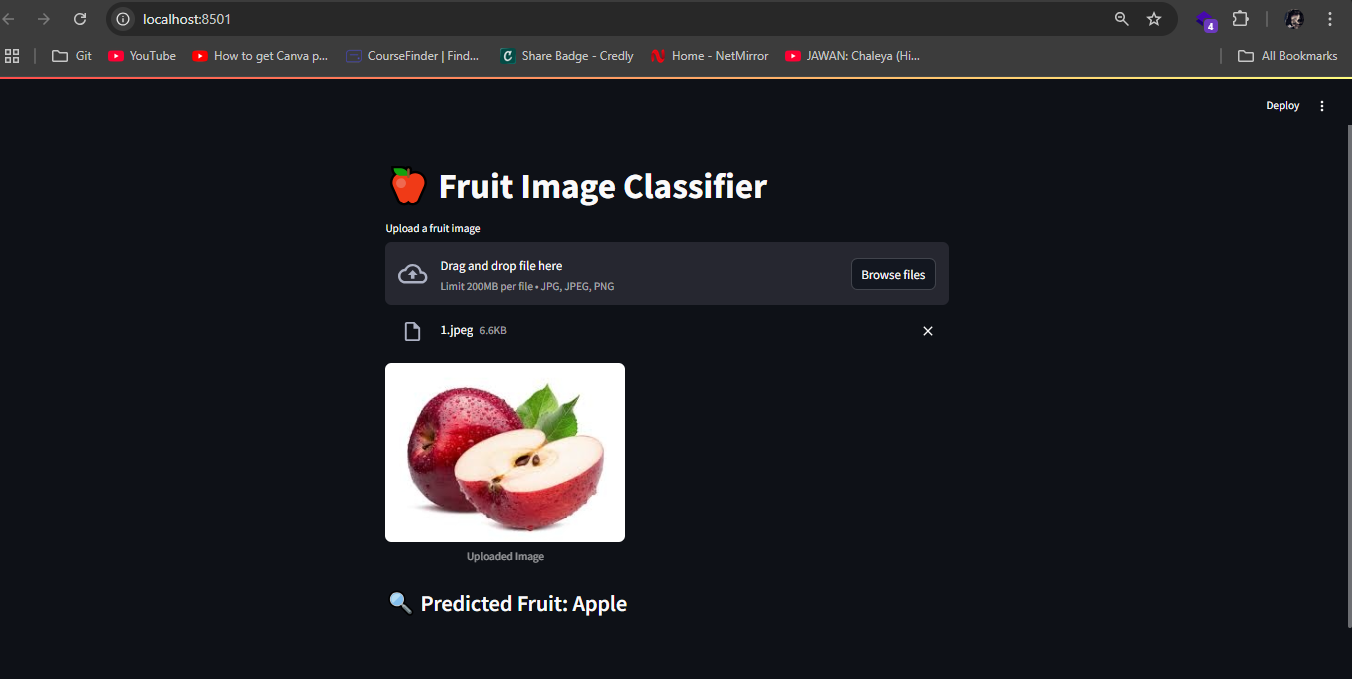


## 2. Objective
The objective of this project is to develop an image classification model that can accurately identify different types of fruits using a custom dataset and deep learning techniques.

## 3. Tools & Technologies Used
- Python  
- TensorFlow / Keras  
- OpenCV  
- Matplotlib / Seaborn  
- Google Colab / Jupyter Notebook  
- Custom Fruit Image Dataset  
- Streamlink

## 4. Dataset Information
The dataset used is a custom image dataset of fruits, organized into the following structure:

- Total Classes: 10 (Apple, Banana, Orange , ... etc )  
- Image Format: JPG/PNG  
- Images were resized and normalized during preprocessing.

## 5. Methodology
1. **Image Preprocessing**: Resizing all images to a standard size, normalization of pixel values.
2. **Model Building**: Designed a Convolutional Neural Network from scratch using Keras.
3. **Training**: Model trained on the training dataset with validation split.
4. **Evaluation**: Accuracy and loss plotted, confusion matrix created.
5. **Testing**: Final evaluation on test dataset and custom prediction images.

## 6. Results
- **Training Accuracy**: ~89%  
- **Validation Accuracy**: ~64%  
- **Test Accuracy**: ~90%  
- **Output**: The model was able to predict the fruit name from input images with high accuracy.  
- **Visualization**: Training curves and confusion matrix were plotted for performance analysis.

## 7. Challenges Faced
- Managing dataset imbalance across classes  
- Initial overfitting due to deep network architecture  
- Tuning hyperparameters like learning rate, batch size, and number of epochs

## 8. Conclusion
The fruit image classifier successfully identified fruit types using a CNN model trained on a custom dataset. The project demonstrated the application of deep learning techniques in real-world classification problems and achieved promising accuracy on unseen data.

## 9. Future Scope
- Expand dataset to include more fruit types  
- Improve accuracy using transfer learning models like MobileNet or EfficientNet  
- Deploy model as a web or mobile application using Flask, Streamlit, or React Native




## **Data Loader** 

In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

def load_data(folder, img_size=(100, 100), test_size=0.2):
    X, y = [], []
    classes = sorted(os.listdir(folder))
    for label in classes:
        label_path = os.path.join(folder, label)
        if not os.path.isdir(label_path): continue
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
            except:
                continue
    lb = LabelBinarizer()
    y_enc = lb.fit_transform(y)
    X = np.array(X, dtype=np.float32) / 255.0
    y_enc = np.array(y_enc)
    return train_test_split(X, y_enc, test_size=test_size, random_state=42), lb

## **Model Builder**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## **Model Evaluater**

In [ ]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
    
def evaluate_model(model, X_test, y_test, lb):
    y_pred = model.predict(X_test)
    y_pred_labels = lb.inverse_transform(y_pred)
    y_true_labels = lb.inverse_transform(y_test)

    report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
    with open('outputs/metrics.json', 'w') as f:
        json.dump(report, f, indent=4)

    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=lb.classes_)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('outputs/confusion_matrix.png')

## **Train Model**

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
    checkpoint = ModelCheckpoint('outputs/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    # Plotting Accuracy and Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('outputs/training_plots.png')

## **Model Prediction**

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import cv2

def predict_image(img_path, lb, img_size=(100, 100)):
    model = load_model('outputs/model.h5')
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    return lb.classes_[np.argmax(prediction)]

## **GUI Builder**

In [ ]:
import streamlit as st
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from src.data_loader import load_data
from src.predict import predict_image

st.set_page_config(page_title="Fruit Classifier", layout="centered")
st.title("🍎 Fruit Image Classifier")

model = load_model("outputs/model.h5")
(X_train, X_val, y_train, y_val), lb = load_data('image_data/train')

uploaded_file = st.file_uploader("Upload a fruit image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, 1)
    img_resized = cv2.resize(img, (100, 100)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    prediction = model.predict(img_input)
    pred_label = lb.classes_[np.argmax(prediction)]

    st.image(img, channels="BGR", caption="Uploaded Image", width=300)
    st.subheader(f"🔍 Predicted Fruit: {pred_label}")

## **Main Loader**

In [ ]:
from src.data_loader import load_data
from src.model_builder import build_model
from src.train_model import train_model
from src.evaluate_model import evaluate_model

# Main script to load data, build model, train, and evaluate

(X_train, X_val, y_train, y_val), lb = load_data('image_data/train')
model = build_model((100, 100, 3), len(lb.classes_))
train_model(model, X_train, y_train, X_val, y_val)
evaluate_model(model, X_val, y_val, lb)

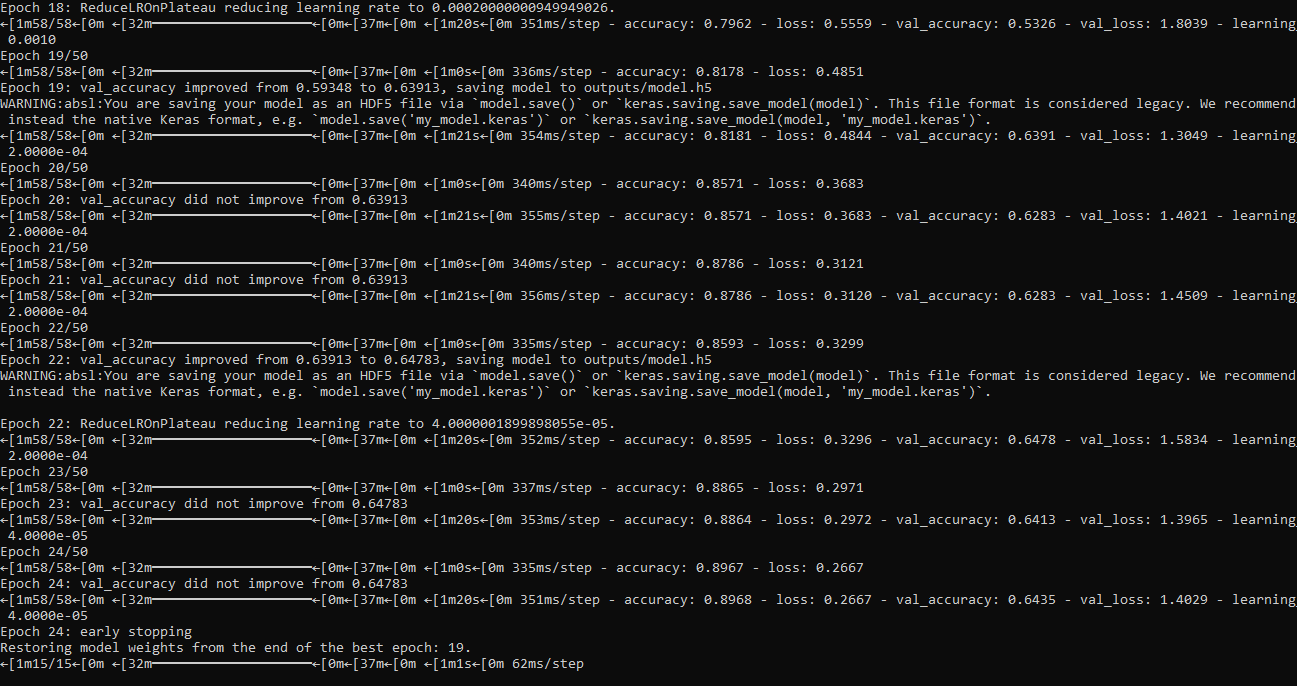

## **Confusion Matrix**

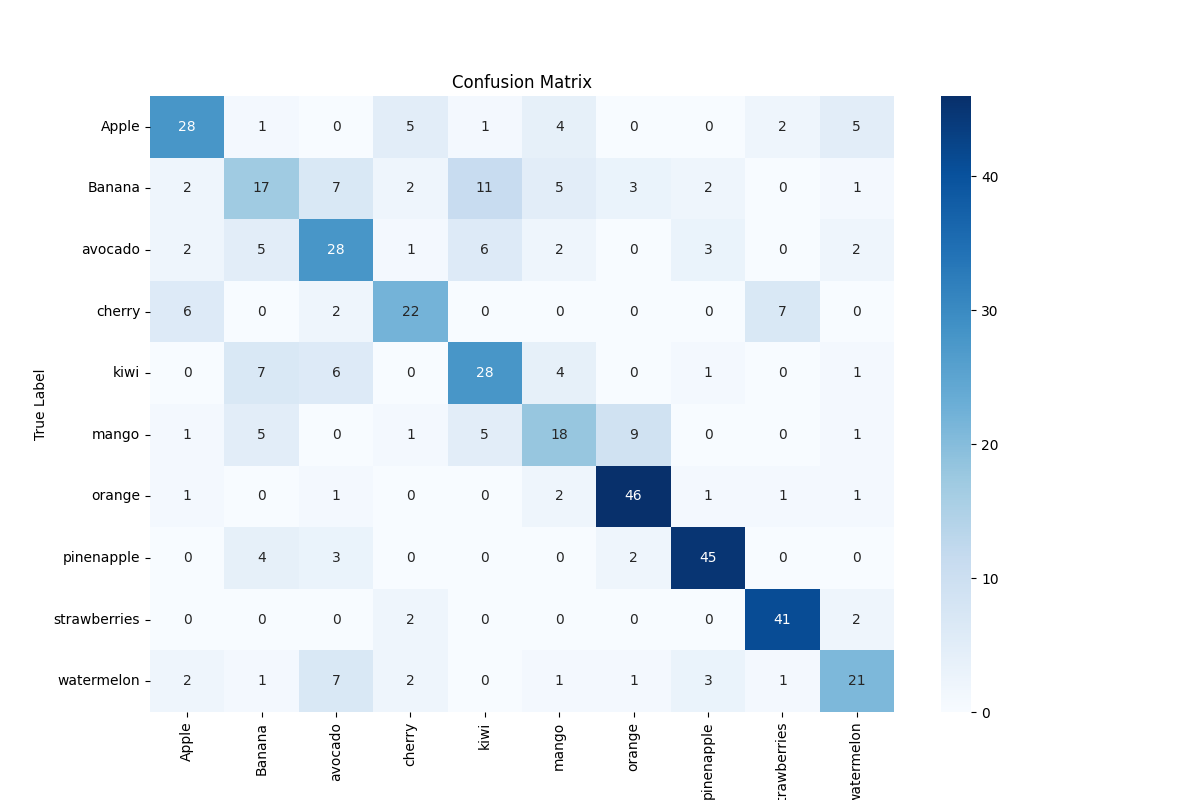

## **Training Plots**

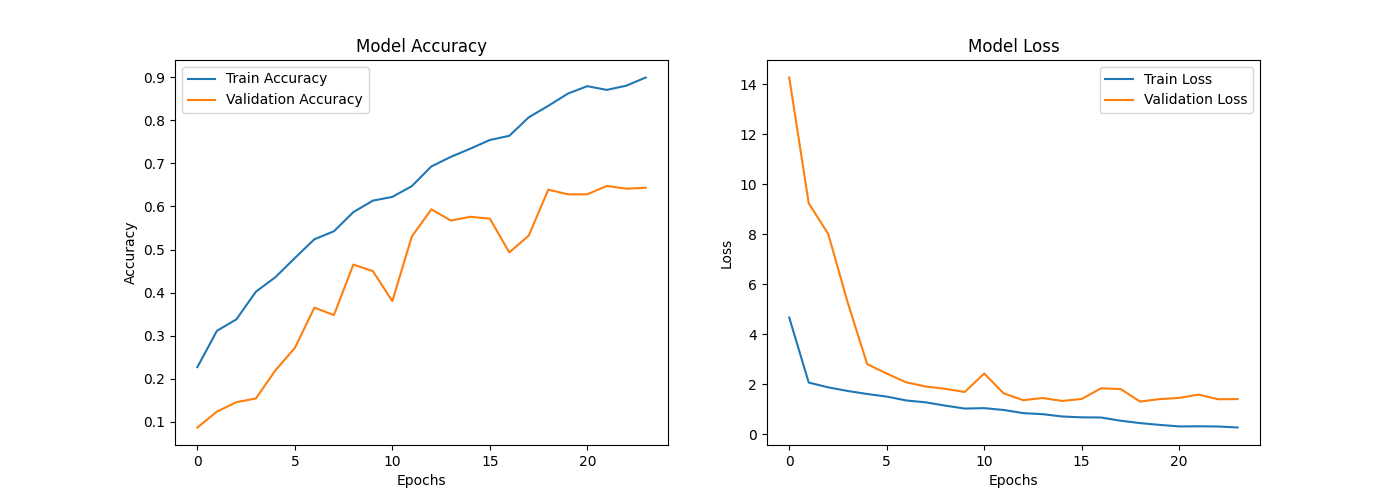

# Fruit-image-classification"# Fruit-image-classification


### Step Follow For Run Code

## Dataset
- `image_data/train/`: Training dataset with subfolders named by fruit type.
- `image_data/test/`: Testing dataset for final evaluation.
- `image_data/predict/`: Additional images for manual predictions.

## Features
- From-scratch CNN architecture
- Model training with validation split
- Evaluation metrics: Accuracy, Precision, Recall, F1-score
- Confusion matrix and training history visualizations
- Prediction script for new unseen images
- Streamlit-based GUI for easy image upload and classification

## Running the Project
1. Install dependencies:
```bash
pip install -r requirements.txt
```
2. Run training:
```bash
python main.py
```
3. Launch GUI:
```bash
streamlit run gui/app.py
```

## Output Files
- `outputs/model.h5`: Best trained model
- `outputs/metrics.json`: Evaluation metrics
- `outputs/confusion_matrix.png`: Confusion matrix
- `outputs/training_plots.png`: Accuracy and loss over epochs

